# **Load libraries**

In [1]:
!pip install python-Levenshtein datashader bokeh holoviews scikit-image colorcet umap-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=ec346f80f6c3c73762300f3e2c68ffb74ba60ebd0224beb33e4104cece0b7ec8
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from umap import UMAP
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import torch
from sklearn.manifold import TSNE
import umap.plot
import Levenshtein as lev
from sklearn.cluster import DBSCAN
from sklearn.preprocessing  import MinMaxScaler
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import jensenshannon
import concurrent.futures
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
def norm_dist(seq1, seq2):
    lev_dist = lev.distance(seq1, seq2)
    return 2*lev_dist/(len(seq1) + len(seq2) + lev_dist)

norm_dist('lew', 'lv')

0.5714285714285714

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
sns.set_style("white")

# **Load sequences and tensors**

In [6]:
#seqs = pd.read_csv(f'/content/drive/MyDrive/Oslo/data/trastuzumab/trastuzumab_subset.csv', sep=',')
seqs = pd.read_csv(f'/content/drive/MyDrive/Oslo/data/all_data/all_data.csv', sep=';')
#seqs = pd.read_csv(f'/content/drive/MyDrive/Oslo/data/trastuzumab/Merged_unique.csv', sep=',')
#seqs = pd.read_csv(f'/content/drive/MyDrive/Oslo/data/covabdab/covabdab.csv', sep=',')

#seqs.rename(columns={'VHorVHH':'junction_aa'},  inplace=True)
#seqs = seqs[seqs['dataset'] == 'trastuzumab']
seqs['id'] = np.arange(1, len(seqs) + 1)

seqs

<ipython-input-6-3d21a1056bdf>:2: DtypeWarning: Columns (0,1,2,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  seqs = pd.read_csv(f'/content/drive/MyDrive/Oslo/data/all_data/all_data.csv', sep=';')


,Protein + Epitope,v_call,j_call,junction_aa,dataset,id,duplicate_count,affinity,d_call,c_call,repertoire_id,junction_length
0,S; RBD,IGHV3-53 (Human),IGHJ4 (Human),CARDLVVYGLDYW,covabdab,1,NaN,NaN,NaN,NaN,NaN,13
1,S; RBD,IGHV3-11 (Human),IGHJ4 (Human),CAREFDLTKIIMVPPYW,covabdab,2,NaN,NaN,NaN,NaN,NaN,17
2,S; RBD,IGHV3-30 (Human),IGHJ4 (Human),CARDSSGWHWGVPFDYW,covabdab,3,NaN,NaN,NaN,NaN,NaN,17
3,S; RBD,IGHV3-53 (Human),IGHJ3 (Human),CVRGSGGIHDAFDIW,covabdab,4,NaN,NaN,NaN,NaN,NaN,15
4,S; RBD,IGHV3-53 (Human),IGHJ4 (Human),CARVDPRYEGFDYW,covabdab,5,NaN,NaN,NaN,NaN,NaN,14
...,...,...,...,...,...,...,...,...,...,...,...,...
2134046,NaN,NaN,NaN,CVRNNTKGYSSSWFVAFDIW,maria,2134047,1.0,NaN,NaN,NaN,NaN,20
2134047,NaN,NaN,NaN,CATSSGSANYYYYYMDVW,maria,2134048,1.0,NaN,NaN,NaN,NaN,18
2134048,NaN,NaN,NaN,CAKGDPEIITMIVVVTKISLYW,maria,2134049,1.0,NaN,NaN,NaN,NaN,22
2134049,NaN,NaN,NaN,CASHPTTVTIHPHWFDPW,maria,2134050,1.0,NaN,NaN,NaN,NaN,18


In [7]:
tensors = torch.load(f'drive/MyDrive/Oslo/data/all_data/output/esm2/all_data.pt').numpy()
tensors

array([[ 0.0165359 ,  0.09836441,  0.08451218, ...,  0.02045532,
        -0.00949972,  0.04278376],
       [ 0.03494602,  0.06543857,  0.02455574, ..., -0.03105022,
        -0.07298544, -0.00877932],
       [ 0.02155516,  0.11110472,  0.07370144, ...,  0.03026756,
        -0.02370827,  0.08511717],
       ...,
       [ 0.03574988,  0.03490529,  0.05695289, ...,  0.03252791,
        -0.03586698,  0.02588152],
       [ 0.01984302,  0.14281625,  0.01913723, ..., -0.06762866,
        -0.01449933, -0.06972364],
       [ 0.03005114,  0.07345476,  0.09382471, ...,  0.050596  ,
        -0.0268468 ,  0.05022966]], dtype=float32)

In [8]:
tensors_df = pd.DataFrame({
    'id': np.arange(1, len(tensors) + 1),
    'embedding': list(tensors)  # Convert the array of arrays into a list to be stored in the DataFrame
})

tensors_df

,id,embedding
0,1,"[0.016535902, 0.098364405, 0.08451218, 0.07570..."
1,2,"[0.034946017, 0.06543857, 0.024555739, 0.06877..."
2,3,"[0.021555165, 0.11110472, 0.07370144, 0.090482..."
3,4,"[0.0057980497, 0.090299375, 0.09269716, 0.0350..."
4,5,"[-0.007613844, 0.12992819, 0.003057226, 0.0977..."
...,...,...
2134046,2134047,"[0.031164575, 0.07445412, 0.11935415, 0.136152..."
2134047,2134048,"[0.06225334, 0.09700576, 0.04691232, 0.1647059..."
2134048,2134049,"[0.03574988, 0.03490529, 0.056952894, 0.064391..."
2134049,2134050,"[0.019843016, 0.14281625, 0.019137233, 0.00460..."


In [9]:
df = pd.merge(seqs, tensors_df, on='id')
df = df[['junction_aa', 'id', 'embedding', 'affinity', 'dataset']] #
df = df[df['dataset'] == 'trastuzumab'] #
df = df[df['affinity'] != 'mb']
df['junction_length'] = df['junction_aa'].apply(len)
#df = df[df['junction_length'] <= 40] #

df

,junction_aa,id,embedding,affinity,dataset,junction_length
11467,CSRIASVAFTCSLYW,11468,"[0.08607771, 0.1267628, 0.15658017, 0.15222932...",lb,trastuzumab,15
11468,CSRIASGLLTLYHYW,11469,"[0.08095949, 0.08205593, 0.09087815, 0.0948732...",lb,trastuzumab,15
11469,CSRWATFGLYAHRYW,11470,"[0.074350245, 0.10862581, 0.08118942, 0.079310...",lb,trastuzumab,15
11470,CSRWSMFGLYTFCYW,11471,"[0.11971326, 0.045084246, 0.15607142, 0.164883...",lb,trastuzumab,15
11471,CSRYVTNGFYAYHYW,11472,"[0.06607033, 0.069482096, 0.02638524, 0.105626...",lb,trastuzumab,15
...,...,...,...,...,...,...
345798,CSRWRAFRTYTFEYW,345799,"[0.0957916, 0.118075535, 0.1332415, 0.11102016...",hb,trastuzumab,15
345799,CSRWARARMYSYDYW,345800,"[0.090603486, 0.10823231, 0.06844074, 0.112363...",hb,trastuzumab,15
345800,CSRYKVSGHYALDYW,345801,"[0.049668964, 0.050600886, 0.09501328, 0.10028...",hb,trastuzumab,15
345801,CSRYIHVGFYAHVYW,345802,"[0.07180209, 0.0982526, 0.056150246, 0.0312086...",hb,trastuzumab,15


In [10]:
df_hb = df[df['affinity'] == 'hb']

#df_hb = df[df['dataset'] == 'covabdab'] #
#df_hb['affinity'] = 'hb' #

df_hb

,junction_aa,id,embedding,affinity,dataset,junction_length
173653,CSRWGGDGFTHLTYW,173654,"[0.038120218, 0.08169616, 0.120041564, 0.09792...",hb,trastuzumab,15
173654,CSRYTAPSFYTFDYW,173655,"[0.06599786, 0.15759282, 0.083128445, 0.172919...",hb,trastuzumab,15
173655,CSRWAAGRSYTFDYW,173656,"[0.039980598, 0.13780491, 0.08726641, 0.142348...",hb,trastuzumab,15
173656,CSRWAAGRFYAFDYW,173657,"[0.038433556, 0.14572363, 0.05692141, 0.121157...",hb,trastuzumab,15
173657,CSRWNAPSFYALNYW,173658,"[0.060799345, 0.12986624, 0.10121548, 0.190596...",hb,trastuzumab,15
...,...,...,...,...,...,...
345798,CSRWRAFRTYTFEYW,345799,"[0.0957916, 0.118075535, 0.1332415, 0.11102016...",hb,trastuzumab,15
345799,CSRWARARMYSYDYW,345800,"[0.090603486, 0.10823231, 0.06844074, 0.112363...",hb,trastuzumab,15
345800,CSRYKVSGHYALDYW,345801,"[0.049668964, 0.050600886, 0.09501328, 0.10028...",hb,trastuzumab,15
345801,CSRYIHVGFYAHVYW,345802,"[0.07180209, 0.0982526, 0.056150246, 0.0312086...",hb,trastuzumab,15


In [11]:
df_lb = df[df['affinity'] == 'lb']

#df_lb = df[df['dataset'] == 'ireceptor'] #
#df_lb['affinity'] = 'lb' #

df_lb

,junction_aa,id,embedding,affinity,dataset,junction_length
11467,CSRIASVAFTCSLYW,11468,"[0.08607771, 0.1267628, 0.15658017, 0.15222932...",lb,trastuzumab,15
11468,CSRIASGLLTLYHYW,11469,"[0.08095949, 0.08205593, 0.09087815, 0.0948732...",lb,trastuzumab,15
11469,CSRWATFGLYAHRYW,11470,"[0.074350245, 0.10862581, 0.08118942, 0.079310...",lb,trastuzumab,15
11470,CSRWSMFGLYTFCYW,11471,"[0.11971326, 0.045084246, 0.15607142, 0.164883...",lb,trastuzumab,15
11471,CSRYVTNGFYAYHYW,11472,"[0.06607033, 0.069482096, 0.02638524, 0.105626...",lb,trastuzumab,15
...,...,...,...,...,...,...
173648,CSRYKDGGFYAKAYW,173649,"[-0.003322058, 0.11350301, 0.007520077, 0.1672...",lb,trastuzumab,15
173649,CSRGATTAFTRMCYW,173650,"[0.09133129, 0.04434262, 0.15079708, 0.1157826...",lb,trastuzumab,15
173650,CSRGAAQASTNSTYW,173651,"[0.047490355, 0.14121619, 0.13806246, 0.145991...",lb,trastuzumab,15
173651,CSRCCLFALYVFFYW,173652,"[0.09276049, 0.062364586, 0.16183639, 0.130448...",lb,trastuzumab,15


In [12]:
df_hb_50percent = df_hb.sample(n=min(len(df_hb), len(df_lb)), random_state=42)
df_lb_50percent = df_lb.sample(n=min(len(df_hb), len(df_lb)), random_state=42)
df_hblb_50percent = pd.concat([df_hb_50percent, df_lb_50percent], ignore_index=True)
df_hblb_50percent['id'] = range(1, len(df_hblb_50percent) + 1)

df_hblb_50percent

,junction_aa,id,embedding,affinity,dataset,junction_length
0,CSRFDGGRFYTFDYW,1,"[0.01841523, 0.10883053, 0.092452966, 0.161334...",hb,trastuzumab,15
1,CSRYAPCHLYANAYW,2,"[0.03716231, 0.14976339, 0.026365442, 0.112617...",hb,trastuzumab,15
2,CSRWGGSSLYALNYW,3,"[0.08295396, 0.07689785, 0.12391083, 0.1732934...",hb,trastuzumab,15
3,CSRYIGVTFYPFEYW,4,"[0.077707306, 0.09854009, 0.07546774, 0.109622...",hb,trastuzumab,15
4,CSRVAGVGFYVYAYW,5,"[0.042559367, 0.10545693, 0.115317784, 0.09026...",hb,trastuzumab,15
...,...,...,...,...,...,...
324367,CSRWNHGSLYDHWYW,324368,"[0.053179685, 0.07761029, 0.05554117, 0.076991...",lb,trastuzumab,15
324368,CSRIATVAFTCSAYW,324369,"[0.054196946, 0.122094065, 0.11651694, 0.15873...",lb,trastuzumab,15
324369,CSRWPDATMYLFEYW,324370,"[0.060977947, 0.10644616, 0.11695564, 0.125107...",lb,trastuzumab,15
324370,CSRYRHGGFYKLDYW,324371,"[0.025763327, 0.10062254, 0.040327653, 0.11328...",lb,trastuzumab,15


In [13]:
df_hblb_50percent_shuffled = df_hblb_50percent.copy()
df_hblb_50percent_shuffled['affinity'] = df_hblb_50percent['affinity'].sample(frac=1).reset_index(drop=True)

df_hblb_50percent_shuffled['id'] = range(1, len(df_hblb_50percent_shuffled) + 1)

df_hblb_50percent_shuffled

,junction_aa,id,embedding,affinity,dataset,junction_length
0,CSRFDGGRFYTFDYW,1,"[0.01841523, 0.10883053, 0.092452966, 0.161334...",lb,trastuzumab,15
1,CSRYAPCHLYANAYW,2,"[0.03716231, 0.14976339, 0.026365442, 0.112617...",lb,trastuzumab,15
2,CSRWGGSSLYALNYW,3,"[0.08295396, 0.07689785, 0.12391083, 0.1732934...",lb,trastuzumab,15
3,CSRYIGVTFYPFEYW,4,"[0.077707306, 0.09854009, 0.07546774, 0.109622...",lb,trastuzumab,15
4,CSRVAGVGFYVYAYW,5,"[0.042559367, 0.10545693, 0.115317784, 0.09026...",hb,trastuzumab,15
...,...,...,...,...,...,...
324367,CSRWNHGSLYDHWYW,324368,"[0.053179685, 0.07761029, 0.05554117, 0.076991...",lb,trastuzumab,15
324368,CSRIATVAFTCSAYW,324369,"[0.054196946, 0.122094065, 0.11651694, 0.15873...",lb,trastuzumab,15
324369,CSRWPDATMYLFEYW,324370,"[0.060977947, 0.10644616, 0.11695564, 0.125107...",lb,trastuzumab,15
324370,CSRYRHGGFYKLDYW,324371,"[0.025763327, 0.10062254, 0.040327653, 0.11328...",hb,trastuzumab,15


In [14]:
df_hb_1000 = df_hb.sample(n=1000, random_state=42)
df_lb_1000 = df_lb.sample(n=1000, random_state=42)

df_hblb_1000 = pd.concat([df_hb_1000, df_lb_1000], ignore_index=True)
df_hblb_1000['id'] = range(0, len(df_hblb_1000))

df_hblb_1000

,junction_aa,id,embedding,affinity,dataset,junction_length
0,CSRFDGGRFYTFDYW,0,"[0.01841523, 0.10883053, 0.092452966, 0.161334...",hb,trastuzumab,15
1,CSRYAPCHLYANAYW,1,"[0.03716231, 0.14976339, 0.026365442, 0.112617...",hb,trastuzumab,15
2,CSRWGGSSLYALNYW,2,"[0.08295396, 0.07689785, 0.12391083, 0.1732934...",hb,trastuzumab,15
3,CSRYIGVTFYPFEYW,3,"[0.077707306, 0.09854009, 0.07546774, 0.109622...",hb,trastuzumab,15
4,CSRVAGVGFYVYAYW,4,"[0.042559367, 0.10545693, 0.115317784, 0.09026...",hb,trastuzumab,15
...,...,...,...,...,...,...
1995,CSRISSEAYTFILYW,1995,"[0.10000443, 0.14315782, 0.16383441, 0.1662579...",lb,trastuzumab,15
1996,CSRWTHTSMYVLAYW,1996,"[0.14174685, 0.09305915, 0.16668437, 0.0625520...",lb,trastuzumab,15
1997,CSRLIEVSFYMFSYW,1997,"[0.11296277, 0.08963362, 0.1791828, 0.16879454...",lb,trastuzumab,15
1998,CSRGCTVLLTLYNYW,1998,"[0.069323465, 0.0634958, 0.15810268, 0.1095240...",lb,trastuzumab,15


In [ ]:
!rm *

rm: cannot remove 'drive': Is a directory
rm: cannot remove 'sample_data': Is a directory


# **Calculate the pairwise distances**

In [21]:
dataframe = df_hblb_1000

# Initialize dictionaries to store distances
euclidean_distances = {}

total_pairs = len(dataframe) * (len(dataframe) - 1) / 2  # Calculates the total number of sequence pairs

# Calculate pairwise distances
with tqdm(total=total_pairs, desc='Calculating distances', unit='pair') as pbar:
    for i in range(len(dataframe) - 1):
        for j in range(i + 1, len(dataframe)):
            embed1 = dataframe.iloc[i]['embedding']
            embed2 = dataframe.iloc[j]['embedding']
            euclidean_distances[(i, j)] = distance.euclidean(embed1, embed2)

            # Update the progress bar
            pbar.update()

# Display the results
print("Pairwise Euclidean distances:", euclidean_distances)

Calculating distances: 100%|██████████| 1999000/1999000.0 [06:59<00:00, 4765.86pair/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#levenshtein_list = list(levenshtein_distances.values())
euclidean_list = list(euclidean_distances.values())

In [ ]:
#levenshtein_distances_hb_lb = levenshtein_distances
euclidean_distances_hb_lb = euclidean_distances

#levenshtein_list_hb_lb = levenshtein_list
euclidean_list_hb_lb = euclidean_list

In [ ]:
sns.set_style("white")

hblb = euclidean_list_hb_lb

# Calculate median
median_hb_lb = np.median(hblb)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Calculate common bins for all histograms
all_values = hblb
min_bin = min(all_values)
max_bin = max(all_values)
bin_width = (max_bin - min_bin) / 50  # Specify number of bins you want
bins = np.arange(min_bin, max_bin + bin_width, bin_width)

# Draw the histograms using the same bins for all distributions
sns.histplot(hblb, label="HB-LB", kde=True, bins=bins)

# Plot the medians
plt.axvline(median_hb_lb, color='#003f5c', linestyle='dashed', linewidth=1)

# Add legend, labels and title
#plt.legend(title='Histogram')
plt.xlabel('Pairwise Euclidean distance')
plt.ylabel('Frequency')
plt.title('Pairwise Euclidean distance distribution')

#plt.xlim(0.5, 4.5)

# Display the plot
plt.tight_layout()
plt.savefig('hist_euclidean.png')  # Changed file name to match the plot content
plt.show()

In [ ]:
df_hblb_1000

,aa_cdr3_seq,count,affinity,id,junction_aa,embedding,junction_length
0,CAGGRYYTFV,2,high,0,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[0.014317844, 0.008990993, -0.10423941, -0.052...",121
1,WPNGGFYSFE,2,high,1,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[-0.026263457, 0.0076838657, -0.10189775, -0.0...",121
2,WSVPGMYAFV,6,high,2,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[-0.0014751551, 0.011178245, -0.09554852, -0.0...",121
3,WRRPGMYVID,5,high,3,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[-0.006901861, -0.00044845213, -0.091637164, -...",121
4,YSRCGFYQID,6,high,4,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[0.020641113, 0.024400664, -0.096999325, -0.06...",121
...,...,...,...,...,...,...,...
1995,LSPEAFTVFR,3,low,1995,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[0.038353693, 0.008268348, -0.103135936, -0.05...",121
1996,LPHYSMYDFA,2,low,1996,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[0.036286127, 0.009361399, -0.0978113, -0.0352...",121
1997,WAKPSFYMFC,17,low,1997,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[0.011528151, 0.013207154, -0.083253056, -0.05...",121
1998,WTQDSIYAFD,2,low,1998,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,"[0.05505887, 0.025971798, -0.085421704, -0.084...",121


In [ ]:
len(np.arange(0.1, 0.6, 0.05))

10

In [ ]:
#radius_list = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8]
radius_list = np.arange(0.1, 0.6, 0.05)
means = []
all_percentages = []

for affinity_radius in radius_list:

  # Prepare sequence IDs for processing
  sequence_ids = df_hblb_1000['id'].tolist()

  # Function that calculates the percentage for a single reference sequence
  def calculate_percentage(reference_id):
      reference_affinity = df_hblb_1000[df_hblb_1000['id'] == reference_id]['affinity'].iloc[0]
      sequences_within_radius_ids = [pair[1] if pair[0] == reference_id else pair[0]
                                    for pair, distance in euclidean_distances.items()
                                    if reference_id in pair and distance <= affinity_radius]
      same_affinity_count = df_hblb_1000[(df_hblb_1000['id'].isin(sequences_within_radius_ids)) &
                                        (df_hblb_1000['affinity'] == reference_affinity)].shape[0]
      total_within_radius_count = len(sequences_within_radius_ids)
      percentage = (same_affinity_count / total_within_radius_count) * 100 if total_within_radius_count > 0 else 0
      return percentage

  # Create a ProcessPoolExecutor to use all available CPUs
  with concurrent.futures.ProcessPoolExecutor() as executor:
      # Wrap the executor with tqdm for progress tracking
      percentages = list(tqdm(executor.map(calculate_percentage, sequence_ids), total=len(sequence_ids), desc="Calculating percentages"))

  # Calculate the mean percentage
  mean_percentage = np.mean(percentages)
  all_percentages.append(percentages)
  means.append(mean_percentage)

  print(f'Mean percentage across all sequences for R={affinity_radius}: {mean_percentage}%')

Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 27.90it/s]


Mean percentage across all sequences for R=0.1: 0.0%


Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 28.03it/s]

Mean percentage across all sequences for R=0.15000000000000002: 17.229960317460314%



Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 28.08it/s]


Mean percentage across all sequences for R=0.20000000000000004: 54.50934951090885%


Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 28.04it/s]

Mean percentage across all sequences for R=0.25000000000000006: 51.91090129066679%



Calculating percentages: 100%|██████████| 2000/2000 [01:10<00:00, 28.48it/s]


Mean percentage across all sequences for R=0.30000000000000004: 50.96370771437714%


Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 28.00it/s]


Mean percentage across all sequences for R=0.3500000000000001: 50.47202258213449%


Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 27.91it/s]


Mean percentage across all sequences for R=0.40000000000000013: 50.211449304349316%


Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 27.95it/s]


Mean percentage across all sequences for R=0.45000000000000007: 50.07707891302548%


Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 27.99it/s]


Mean percentage across all sequences for R=0.5000000000000001: 50.02048574815176%


Calculating percentages: 100%|██████████| 2000/2000 [01:11<00:00, 27.99it/s]


Mean percentage across all sequences for R=0.5500000000000002: 49.99339024380838%


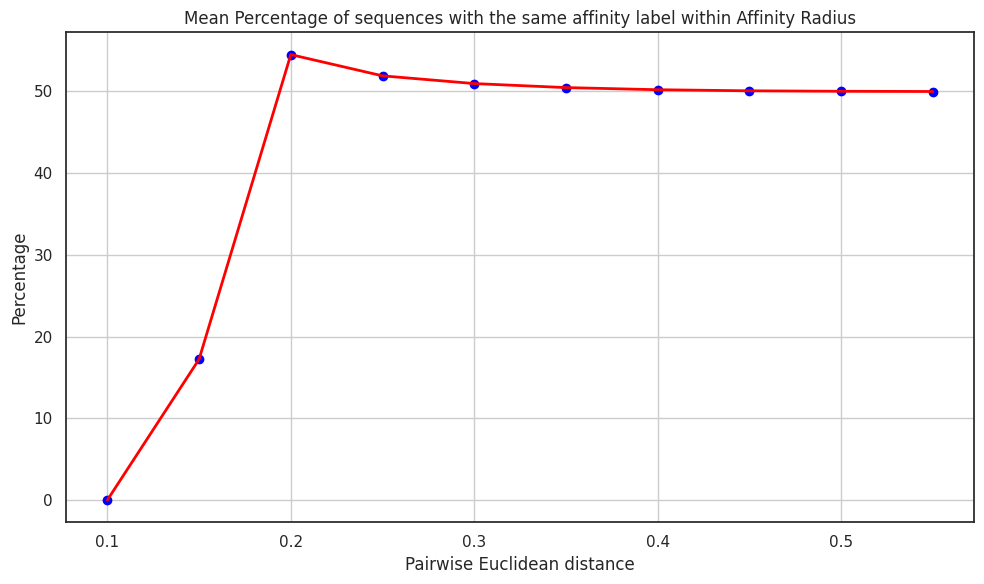

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plotting the scatterplot with connected dots
plt.scatter(radius_list, means, color='blue', label='Mean Percentages')
plt.plot(radius_list, means, color='red', linestyle='-', linewidth=2, markersize=5, label='Trendline')
plt.xlabel('Affinity Radius')
plt.ylabel('Mean Percentage of sequences with the same affinity label')
plt.title('Mean Percentage of sequences with the same affinity label within Affinity Radius')
plt.grid(True)

# Add legend, labels and title
#plt.legend(title='Histogram')
plt.xlabel('Pairwise Euclidean distance')
plt.ylabel('Percentage')

#plt.xlim(0.5, 3.0)

# Display the plot
plt.tight_layout()
plt.savefig('vicinity.png')  # Changed file name to match the plot content
plt.show()

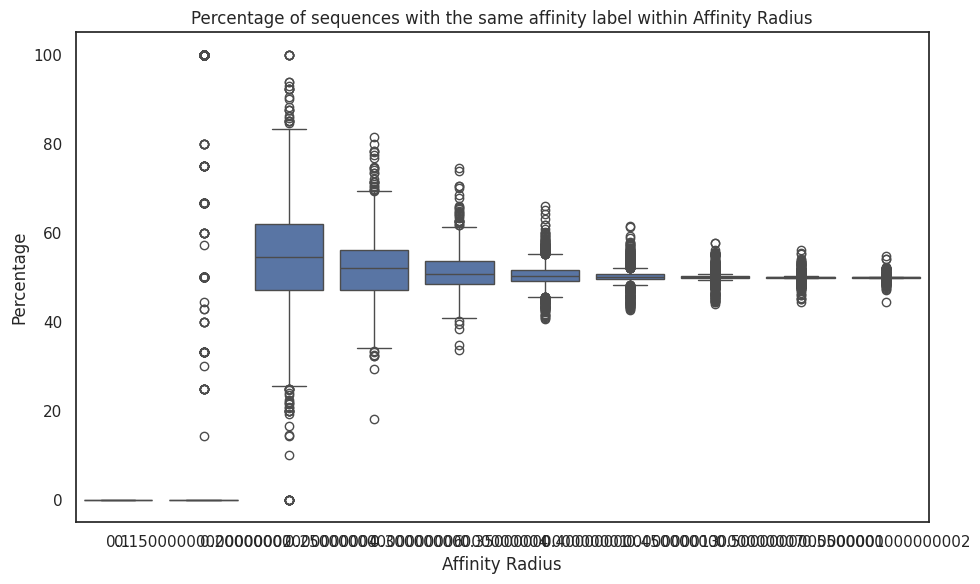

In [ ]:
# Prepare the data for Seaborn
data = []
for radius, percentages in zip(radius_list, all_percentages):
    for percentage in percentages:
        data.append({'Affinity Radius': radius, 'Percentage': percentage})
# Convert raw data to a Pandas DataFrame
df = pd.DataFrame(data)

# Set up the matplotlib figure with a defined size
plt.figure(figsize=(10, 6))

# Use Seaborn to create the boxplot
sns.boxplot(x='Affinity Radius', y='Percentage', data=df), #color='#003f5c')

# Add labels and title to the plot
plt.xlabel('Affinity Radius')
plt.ylabel('Percentage')
plt.title('Percentage of sequences with the same affinity label within Affinity Radius')

# Set the x-axis limits, if necessary
# plt.xlim(0.5, 4.0)  # Uncomment if you need to set specific limits for the x-axis

# Display the plot
plt.tight_layout()
plt.savefig('vicinity_boxplots.png')  # Changed file name to match the plot content
plt.show()

## **Sample size test**

In [32]:
sample_sizes = [1000, 2000]
sampled_dataframes = {}
all_euclidean_distances = {}

for sample_size in sample_sizes:
    # Sample from each group in the affinity column
    sampled_dataframe = pd.concat([
        df_hblb_50percent.query("affinity == 'hb'").sample(int(sample_size / 2)),
        df_hblb_50percent.query("affinity == 'lb'").sample(int(sample_size / 2))
    ])
    sampled_dataframe.reset_index(drop=True, inplace=True)
    sampled_dataframes[sample_size] = sampled_dataframe  # Store the sampled dataframe

    # Dictionary for the distances of the current sample size
    euclidean_distances = {}

    total_pairs = len(sampled_dataframe) * (len(sampled_dataframe) - 1) / 2  # Total number of pairs

    # Calculate pairwise distances
    with tqdm(total=total_pairs, desc=f'Calculating distances for sample size {sample_size}', unit='pair') as pbar:
        for i in range(len(sampled_dataframe) - 1):
            for j in range(i + 1, len(sampled_dataframe)):
                embed1 = sampled_dataframe.iloc[i]['embedding']
                embed2 = sampled_dataframe.iloc[j]['embedding']
                euclidean_distances[(i, j)] = distance.euclidean(embed1, embed2)

                # Update the progress bar
                pbar.update()

    all_euclidean_distances[sample_size] = euclidean_distances  # Store distances for the current sample size

# At this point, sampled_dataframes will contain all the sampled dataframes
# and all_euclidean_distances will contain Euclidean distances for these samples.

Calculating distances for sample size 1000: 100%|██████████| 499500/499500.0 [01:46<00:00, 4693.69pair/s]
Calculating distances for sample size 2000: 100%|██████████| 1999000/1999000.0 [07:07<00:00, 4677.42pair/s]


In [ ]:
radius_list = np.arange(0.1, 0.6, 0.05)
mean_percentages = {}

for sample_size in sample_sizes:
    dataframe = sampled_dataframes[sample_size]  # Retrieve the precomputed dataframe for the sample size
    sequence_ids = dataframe.index.tolist()  # Use DataFrame's index as IDs

    sample_means = []
    for affinity_radius in radius_list:
        def calculate_percentage(sequence_idx):
            reference_affinity = dataframe.loc[sequence_idx, 'affinity']
            sequences_within_radius_idxs = [idx_pair[1] if idx_pair[0] == sequence_idx else idx_pair[0]
                                            for idx_pair, dist in all_euclidean_distances[sample_size].items()
                                            if sequence_idx in idx_pair and dist <= affinity_radius]
            same_affinity_count = dataframe.loc[sequences_within_radius_idxs, 'affinity'].eq(reference_affinity).sum()
            total_within_radius_count = len(sequences_within_radius_idxs)
            percentage = (same_affinity_count / total_within_radius_count) * 100 if total_within_radius_count > 0 else 0
            return percentage

        with concurrent.futures.ProcessPoolExecutor() as executor:
            percentages = list(tqdm(executor.map(calculate_percentage, sequence_ids), total=len(sequence_ids),
                                    desc=f"Calculating percentages for sample size {sample_size}, radius {affinity_radius}"))

        mean_percentage = np.mean(percentages)
        sample_means.append(mean_percentage)

        print(f'Sample size: {sample_size}, Radius: {affinity_radius}, Mean percentage: {mean_percentage}%')

    mean_percentages[sample_size] = sample_means

print("\nMean percentages for all sample sizes:", mean_percentages)

Calculating percentages for sample size 1000, radius 0.1: 100%|██████████| 1000/1000 [00:09<00:00, 105.47it/s]


Sample size: 1000, Radius: 0.1, Mean percentage: 0.0%


Calculating percentages for sample size 1000, radius 0.15000000000000002: 100%|██████████| 1000/1000 [00:09<00:00, 109.45it/s]


Sample size: 1000, Radius: 0.15000000000000002, Mean percentage: 0.0%


Calculating percentages for sample size 1000, radius 0.20000000000000004: 100%|██████████| 1000/1000 [00:09<00:00, 106.48it/s]


Sample size: 1000, Radius: 0.20000000000000004, Mean percentage: 0.0%


Calculating percentages for sample size 1000, radius 0.25000000000000006: 100%|██████████| 1000/1000 [00:09<00:00, 106.25it/s]


Sample size: 1000, Radius: 0.25000000000000006, Mean percentage: 0.0%


Calculating percentages for sample size 1000, radius 0.30000000000000004: 100%|██████████| 1000/1000 [00:09<00:00, 105.11it/s]


Sample size: 1000, Radius: 0.30000000000000004, Mean percentage: 0.0%


Calculating percentages for sample size 1000, radius 0.3500000000000001: 100%|██████████| 1000/1000 [00:09<00:00, 109.41it/s]


Sample size: 1000, Radius: 0.3500000000000001, Mean percentage: 0.0%


Calculating percentages for sample size 1000, radius 0.40000000000000013: 100%|██████████| 1000/1000 [00:09<00:00, 107.53it/s]


Sample size: 1000, Radius: 0.40000000000000013, Mean percentage: 0.2%


Calculating percentages for sample size 1000, radius 0.45000000000000007: 100%|██████████| 1000/1000 [00:09<00:00, 104.82it/s]


Sample size: 1000, Radius: 0.45000000000000007, Mean percentage: 0.2%


Calculating percentages for sample size 1000, radius 0.5000000000000001: 100%|██████████| 1000/1000 [00:10<00:00, 98.71it/s]


Sample size: 1000, Radius: 0.5000000000000001, Mean percentage: 0.4%


Calculating percentages for sample size 1000, radius 0.5500000000000002: 100%|██████████| 1000/1000 [00:14<00:00, 66.94it/s]


Sample size: 1000, Radius: 0.5500000000000002, Mean percentage: 0.8%


Calculating percentages for sample size 2000, radius 0.1: 100%|██████████| 2000/2000 [01:13<00:00, 27.38it/s]


Sample size: 2000, Radius: 0.1, Mean percentage: 0.0%


Calculating percentages for sample size 2000, radius 0.15000000000000002: 100%|██████████| 2000/2000 [01:12<00:00, 27.41it/s]


Sample size: 2000, Radius: 0.15000000000000002, Mean percentage: 0.0%


Calculating percentages for sample size 2000, radius 0.20000000000000004: 100%|██████████| 2000/2000 [01:12<00:00, 27.60it/s]


Sample size: 2000, Radius: 0.20000000000000004, Mean percentage: 0.0%


Calculating percentages for sample size 2000, radius 0.25000000000000006:  63%|██████▎   | 1259/2000 [00:45<00:26, 27.55it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))

# Plot a line for each sample size
for sample_size, means in mean_percentages.items():
    plt.plot(radius_list, means, marker='o', linestyle='-', markersize=5, label=f'Sample size: {sample_size}')

plt.xlabel('Affinity Radius')
plt.ylabel('Mean Percentage of Sequences with the Same Affinity Label')
plt.title('Mean Percentage of Sequences with the Same Affinity Label within Affinity Radius for Different Sample Sizes')
plt.grid(True)

# Add legend to distinguish lines for different sample sizes
plt.legend()

plt.tight_layout()
plt.savefig('vicinity.png')
plt.show()

# **Use knn instead of pairwise distances**

In [ ]:
import multiprocessing

num_cpus = multiprocessing.cpu_count()

print(f"Number of CPUs: {num_cpus}")

Number of CPUs: 8


In [ ]:
len(np.arange(2, 40, 4))

10

In [ ]:
# Function to calculate the percentage of same affinity
def calculate_fraction(neigh, df, index, n_neighbors):
    given_point = df.iloc[index]['embedding']
    given_affinity = df.iloc[index]['affinity']

    distances, indices = neigh.kneighbors([given_point], n_neighbors=n_neighbors+1)
    neighbors_affinity = df.iloc[indices[0][1:]]['affinity']  # exclude the given point itself

    percentage = (neighbors_affinity == given_affinity).sum() / n_neighbors
    return percentage

# Function to calculate the fractions for a specific number of neighbors
def calculate_fractions_for_radius(df, neigh, n):
    percentages = [calculate_fraction(neigh, df, i, n) for i in range(len(df))]
    return n, percentages

# Function to calculate the fractions for all numbers of neighbors
def calculate_fractions_for_data(df, neighbor_numbers, n_cpus):
    neigh = NearestNeighbors()
    neigh.fit(list(df['embedding']))

    results = {}
    with tqdm(total=len(neighbor_numbers), desc="Processing", position=0, leave=True) as pbar:
        for n, percentages in Parallel(n_jobs=n_cpus)(delayed(calculate_fractions_for_radius)(df, neigh, n) for n in neighbor_numbers):
            results[n] = percentages
            pbar.update()
    return results

# Define the range of numbers of neighbors and the number of CPUs
neighbor_numbers = np.arange(2, 40, 4)
num_cpus = -1  # Replace with the number of CPUs you want to use

# Calculate the fractions
fractions_results = calculate_fractions_for_data(df_hblb_1000, neighbor_numbers, num_cpus)

Processing: 100%|██████████| 10/10 [00:59<00:00,  5.98s/it]


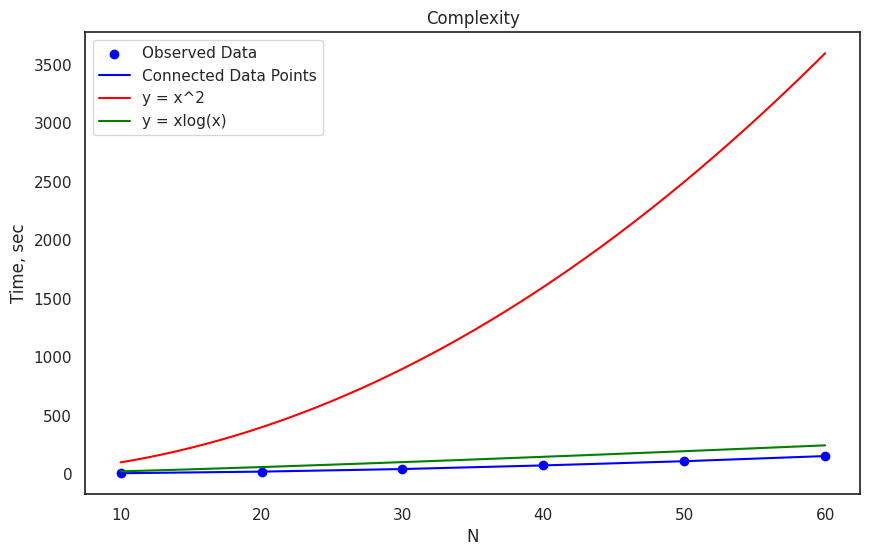

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate y = xlog(x) values
# We use "np.log" which is the natural logarithm
def y_xlogx(x):
    return x * np.log(x)

# Given arrays of x labels and y labels
x_labels = [10, 20, 30, 40, 50, 60]
y_labels = [7, 21, 43, 74, 110, 154]

# Create a figure with a specified size
plt.figure(figsize=(10, 6))

# Scatter plot for the given x and y labels
plt.scatter(x_labels, y_labels, color='blue', label='Observed Data')

# Line plot to connect the dots
plt.plot(x_labels, y_labels, color='blue', label='Connected Data Points')

# Generate a smooth set of x values for plotting the functions
x_range = np.linspace(min(x_labels), max(x_labels), 300)

# Compute y values for y = x^2
y_x2 = x_range**2

# Compute y values for y = xlog(x)
y_xlogx_vals = y_xlogx(x_range)

# Plot the y = x^2 function
plt.plot(x_range, y_x2, color='red', label='y = x^2')

# Plot the y = xlog(x) function
plt.plot(x_range, y_xlogx_vals, color='green', label='y = xlog(x)')

# Titles and labels
plt.title('Complexity')
plt.xlabel('N')
plt.ylabel('Time, sec')

# Legend
plt.legend()

# Save the figure as a file
plt.savefig('complexity.png')

# Display the plot
plt.show()

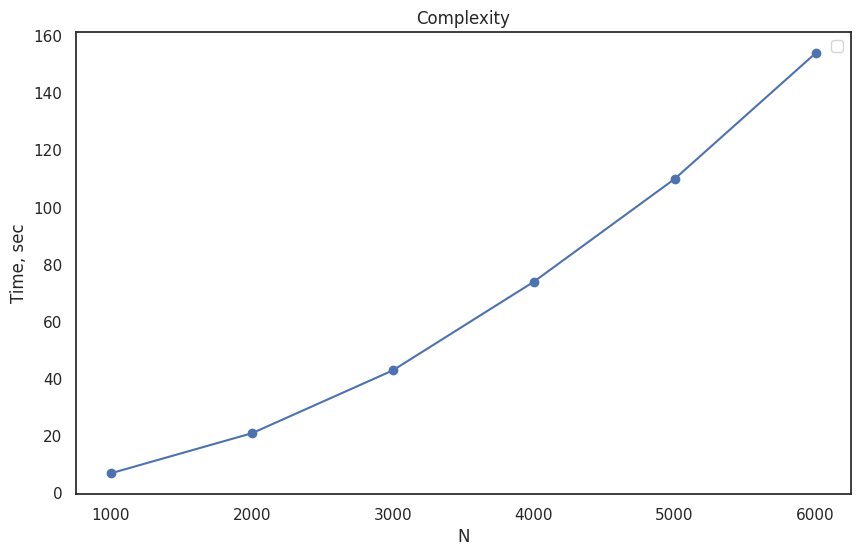

In [ ]:
plt.figure(figsize=(10, 6))

x_labels = [1000, 2000, 3000, 4000, 5000, 6000]
y_labels = [7, 21, 43, 74, 110, 154]

plt.scatter(x_labels, y_labels)
plt.plot(x_labels, y_labels)

# Adding titles and labels
plt.title('Complexity')
plt.xlabel('N')
plt.ylabel('Time, sec')

# Adding a legend
plt.legend()
plt.savefig('complexity.png')
plt.show()

In [ ]:
len(np.arange(2, 32, 4))

8

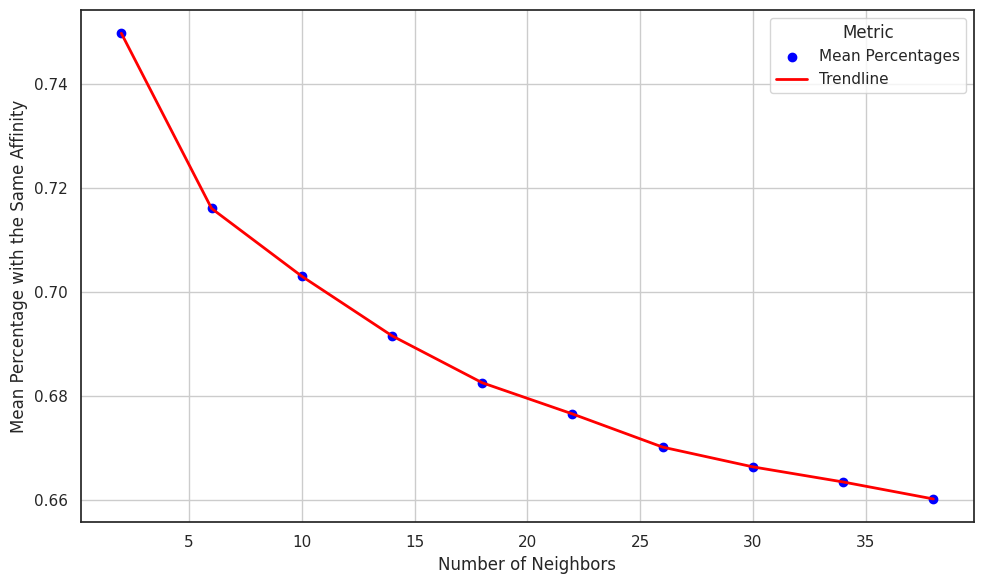

In [ ]:
# Compute the mean fraction percentage for each neighbor number (affinity radius)
neighbor_numbers = sorted(fractions_results.keys())
means = [sum(fractions_results[n]) / len(fractions_results[n]) for n in neighbor_numbers]

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plotting the scatter plot with connected dots
plt.scatter(neighbor_numbers, means, color='blue', label='Mean Percentages')
plt.plot(neighbor_numbers, means, color='red', linestyle='-', linewidth=2, markersize=5, label='Trendline')

# Add legend, labels, and title
plt.legend(title='Metric')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Percentage with the Same Affinity')
#plt.title('Mean Percentage of Sequences with the Same Affinity Label by Number of Neighbors')
plt.grid(True)

# Optionally set x and y limits
# plt.xlim(lower_limit, upper_limit)
# plt.ylim(lower_limit, upper_limit)

# Save the plot to a file and display it
plt.tight_layout()
plt.savefig('vicinity.png')  # Saved image file name
plt.show()

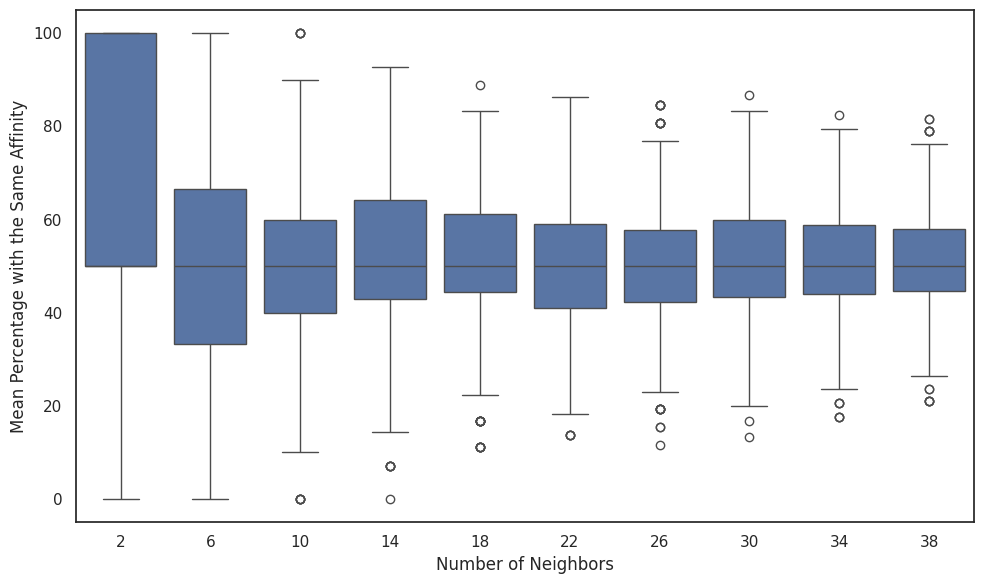

In [ ]:
# Prepare the data for Seaborn
data = []
for radius, percentages in fractions_results.items():
    for percentage in percentages:
        data.append({'Affinity Radius': radius, 'Percentage': percentage * 100})  # Convert fraction to percentage
# Convert raw data to a Pandas DataFrame
df = pd.DataFrame(data)

# Set up the matplotlib figure with a defined size
plt.figure(figsize=(10, 6))

# Use Seaborn to create the boxplot
sns.boxplot(x='Affinity Radius', y='Percentage', data=df)  # , color='#003f5c') - color argument is optional

# Add labels and title to the plot
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Percentage with the Same Affinity')
#plt.title('Percentage of Sequences with the Same Affinity Label Within Affinity Radius')

# Set the x-axis limits, if necessary
# plt.xlim(0.5, 4.0)  # Uncomment if you need to set specific limits for the x-axis

# Display the plot
plt.tight_layout()
plt.savefig('vicinity_boxplots.png')  # Saved image file name
plt.show()

# **Test**

In [ ]:
# Function to calculate the percentage of same affinity
def calculate_fraction(neigh, df, index, n_neighbors):
    given_point = df.iloc[index]['embedding']
    given_affinity = df.iloc[index]['affinity']

    distances, indices = neigh.kneighbors([given_point], n_neighbors=n_neighbors+1)
    neighbors_affinity = df.iloc[indices[0][1:]]['affinity']  # exclude the given point itself

    percentage = (neighbors_affinity == given_affinity).sum() / n_neighbors
    return percentage

# Function to calculate the fractions for a specific number of neighbors
def calculate_fractions_for_radius(df, neigh, n, indices_subset):
    percentages = [calculate_fraction(neigh, df, i, n) for i in indices_subset]
    return n, percentages

# Function to calculate the fractions for all numbers of neighbors
def calculate_fractions_for_data(df, neighbor_numbers, n_cpus, num_points):
    neigh = NearestNeighbors()
    neigh.fit(list(df['embedding']))

    indices_subset = np.random.choice(df.index, size=num_points, replace=False)

    results = {}
    with tqdm(total=len(neighbor_numbers), desc="Processing", position=0, leave=True) as pbar:
        for n, percentages in Parallel(n_jobs=n_cpus)(delayed(calculate_fractions_for_radius)(df, neigh, n, indices_subset) for n in neighbor_numbers):
            results[n] = percentages
            pbar.update()
    return results

# Define the range of numbers of neighbors and the number of CPUs
neighbor_numbers = np.arange(2, 40, 4)
num_cpus = 1  # Replace with the number of CPUs you want to use
num_points = 10

# Calculate the fractions
fractions_results = calculate_fractions_for_data(df_hblb_50percent, neighbor_numbers, num_cpus, num_points)

Processing: 100%|██████████| 10/10 [00:42<00:00,  4.26s/it]


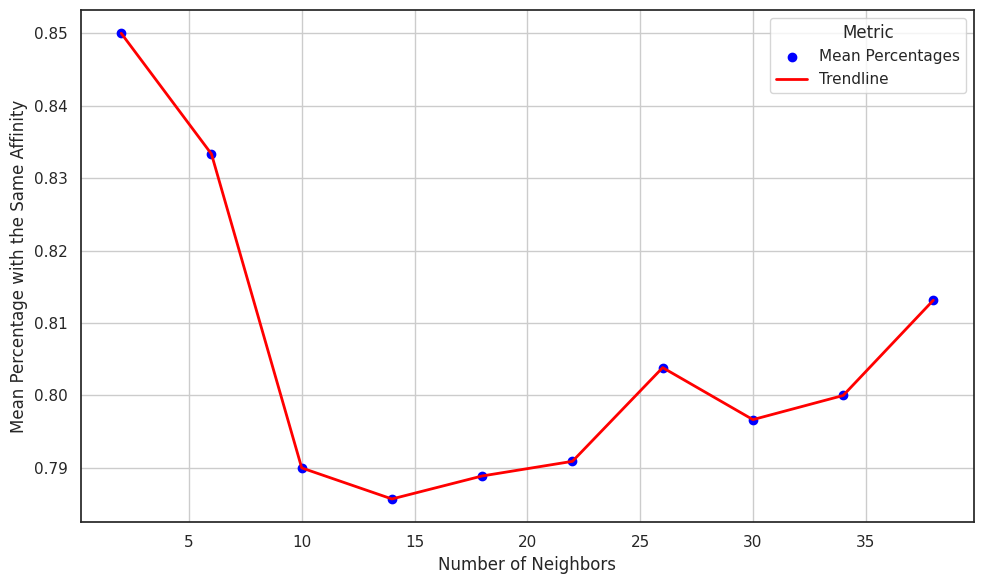

In [ ]:
# Compute the mean fraction percentage for each neighbor number (affinity radius)
neighbor_numbers = sorted(fractions_results.keys())
means = [sum(fractions_results[n]) / len(fractions_results[n]) for n in neighbor_numbers]

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plotting the scatter plot with connected dots
plt.scatter(neighbor_numbers, means, color='blue', label='Mean Percentages')
plt.plot(neighbor_numbers, means, color='red', linestyle='-', linewidth=2, markersize=5, label='Trendline')

# Add legend, labels, and title
plt.legend(title='Metric')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Percentage with the Same Affinity')
#plt.title('Mean Percentage of Sequences with the Same Affinity Label by Number of Neighbors')
plt.grid(True)

# Optionally set x and y limits
# plt.xlim(lower_limit, upper_limit)
# plt.ylim(lower_limit, upper_limit)

# Save the plot to a file and display it
plt.tight_layout()
plt.savefig('vicinity.png')  # Saved image file name
plt.show()

# **Niccolo's code**

In [16]:
def calculate_fraction(neigh, df, indices_slice, n_neighbors, given_index):
    given_affinity = df.iloc[given_index]['affinity']
    neighbors_indices = indices_slice[1:n_neighbors+1]  # Subsetting the indices for n_neighbors
    neighbors_affinity = df.iloc[neighbors_indices]['affinity']
    percentage = (neighbors_affinity == given_affinity).sum()
    percentage = (neighbors_affinity == given_affinity).sum() / len(neighbors_affinity)
    return percentage


def calculate_fractions_for_subset(df, neigh, indices, neighbor_subset, id_index):
    percentages = []
    for n in neighbor_subset:
        for idx, given_index in enumerate(id_index):
            indices_slice = indices[idx]  # Get the correct slice of indices for the current id_index
            percentage = calculate_fraction(neigh, df, indices_slice, n, given_index)
            percentages.append(percentage)
    percentages=  np.mean(percentages)
    return percentages


def calculate_fractions_for_data(df, neighbor_numbers, id_index):
    neigh = NearestNeighbors()
    neigh.fit(list(df['embedding']))
    # Compute the nearest neighbors for the maximum number of neighbors needed
    _, indices = neigh.kneighbors(df.iloc[id_index]['embedding'].tolist(), n_neighbors=max(neighbor_numbers))
    results = {}
    res1=[]
    for n in neighbor_numbers:
        # No parallel processing, direct function call
        result = calculate_fractions_for_subset(df, neigh, indices, [n], id_index)
        res1.append(result)
        # results.update({n: result for n in result})
    return res1


max_neighbors = 40  # This is the maximum number of neighbors you're interested in
neighbor_numbers = np.arange(2, max_neighbors+1, 4)  # This adjusts based on

#id_index = df_hblb_50percent['id'][:1999]  # Assuming these are the indices of your 1000 points

sample_size = 2000

# Sample from each group in affinity column
df_new = pd.concat([
    df_hblb_50percent.query("affinity == 'hb'").sample(int(sample_size/2)),
    df_hblb_50percent.query("affinity == 'lb'").sample(int(sample_size/2))
])
df_new['id'] = range(1, len(df_new) + 1)

# Shuffle the data and extract 'id'
id_index = df_new['id'][:int(sample_size-1)]

fractions_results = calculate_fractions_for_data(df_new, neighbor_numbers, id_index)
fractions_results

[0.7363681840920461,
 0.7090211772552943,
 0.6963981990995498,
 0.686378903737583,
 0.6797565449391362,
 0.674951111919596,
 0.6697579559010274,
 0.6652159413039853,
 0.6632875261159992,
 0.6611008206806106]

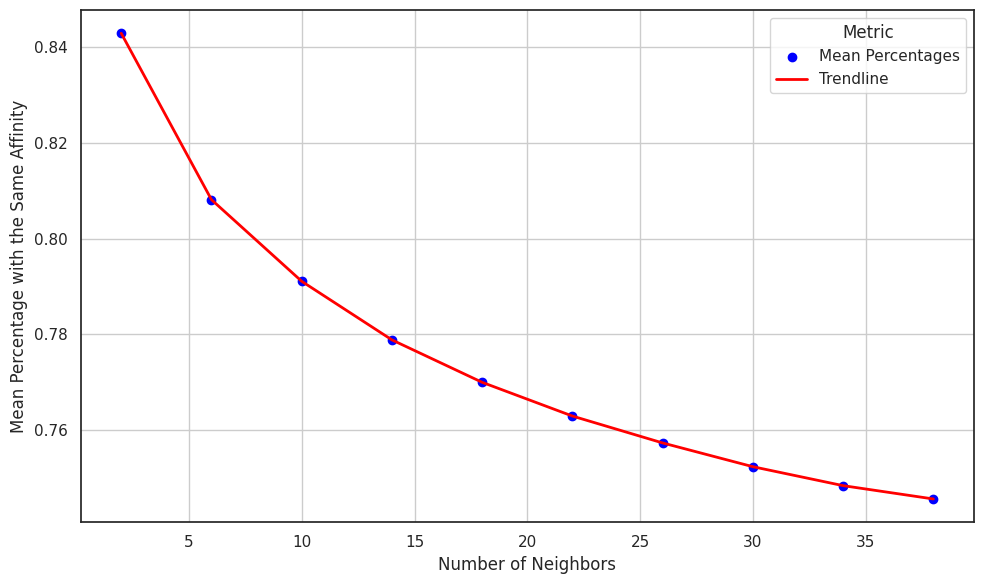

In [ ]:
# Compute the mean fraction percentage for each neighbor number (affinity radius)
means = fractions_results

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plotting the scatter plot with connected dots
plt.scatter(neighbor_numbers, means, color='blue', label='Mean Percentages')
plt.plot(neighbor_numbers, means, color='red', linestyle='-', linewidth=2, markersize=5, label='Trendline')

# Add legend, labels, and title
plt.legend(title='Metric')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Percentage with the Same Affinity')
#plt.title('Mean Percentage of Sequences with the Same Affinity Label by Number of Neighbors')
plt.grid(True)

# Optionally set x and y limits
# plt.xlim(lower_limit, upper_limit)
# plt.ylim(lower_limit, upper_limit)

# Save the plot to a file and display it
plt.tight_layout()
plt.savefig(f'vicinity_{sample_size}.png')  # Saved image file name
plt.show()

## **Sample size test**

In [17]:
max_neighbors = 40  # This is the maximum number of neighbors you're interested in
neighbor_numbers = np.arange(2, max_neighbors+1, 4)  # This adjusts based on

# List of sample sizes
sample_sizes = [1000, 2000, 4000, 8000, 16000, 32000]

# To store fractions results for each sample size
results_for_each_sample_size = {}

# Sample for each size and calculate fractions
for sample_size in sample_sizes:
    df_new = pd.concat([
        df_hblb_50percent.query("affinity == 'hb'").sample(int(sample_size/2)),
        df_hblb_50percent.query("affinity == 'lb'").sample(int(sample_size/2))
    ])
    df_new['id'] = range(1, len(df_new) + 1)
    id_index = df_new['id'][:int(sample_size-1)]
    fractions_results = calculate_fractions_for_data(df_new, neighbor_numbers, id_index)
    results_for_each_sample_size[sample_size] = fractions_results

results_for_each_sample_size

{1000: [0.7202202202202203,
  0.6935268601935269,
  0.6806806806806807,
  0.6716001716001717,
  0.6664998331664997,
  0.6585221585221586,
  0.6527681527681528,
  0.6486486486486487,
  0.6439380557027615,
  0.6408300192083975],
 2000: [0.7431215607803902,
  0.7125229281307321,
  0.6976988494247124,
  0.6899163867648108,
  0.6822577955644489,
  0.6759516121697212,
  0.6717204756224266,
  0.6681340670335169,
  0.6644351587558486,
  0.6608574557549045],
 4000: [0.766816704176044,
  0.7376010669334,
  0.7235558889722431,
  0.7136605579966421,
  0.7065238531855187,
  0.7009593307417763,
  0.6957797141593091,
  0.6907726931732933,
  0.6870320521306797,
  0.6853808046606246],
 8000: [0.7983497937242156,
  0.7698253948410217,
  0.7528316039504939,
  0.7424767381636991,
  0.7345362614771292,
  0.72847174078578,
  0.723287526325406,
  0.718218944034671,
  0.7142841384584839,
  0.7114504177887101],
 16000: [0.8185199074942184,
  0.7856845219492886,
  0.7700231264454029,
  0.7596590858357218,
  0.7

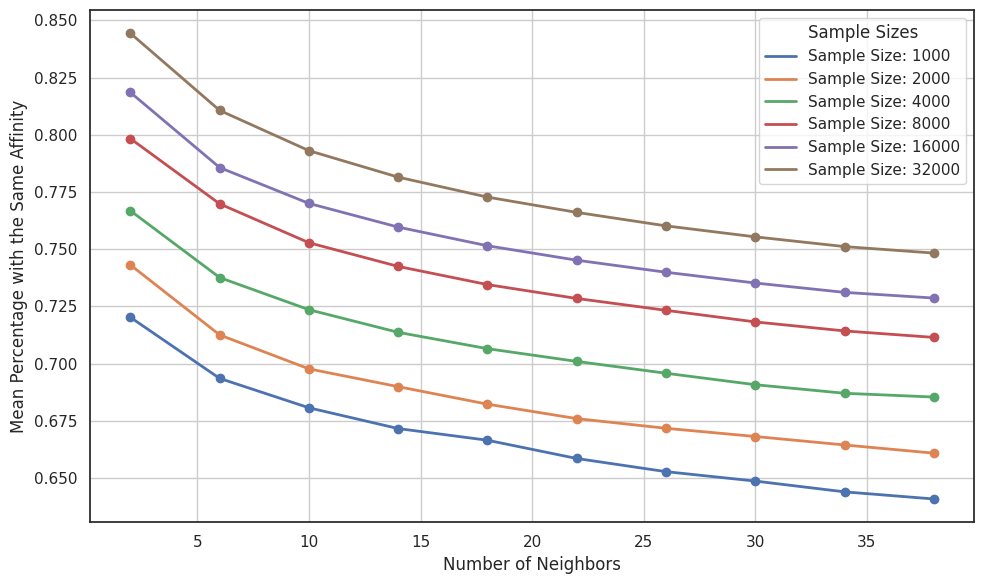

In [20]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Loop over each sample size and plot
for sample_size, means in results_for_each_sample_size.items():
    plt.plot(neighbor_numbers, means, linestyle='-', linewidth=2, label=f'Sample Size: {sample_size}')
    plt.scatter(neighbor_numbers, means)

# Add scatter points for last set of means if needed
#if means is not None:
    #plt.scatter(neighbor_numbers, means, color='blue')  # Color can be adjusted if needed

# Add legend, labels, and title
plt.legend(title='Sample Sizes')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Percentage with the Same Affinity')
#plt.title('Mean Percentage of Sequences with the Same Affinity Label by Number of Neighbors')
plt.grid(True)

# Optionally set x and y limits
# plt.xlim(lower_limit, upper_limit)
# plt.ylim(lower_limit, upper_limit)

# Save the plot to a file and display it
plt.tight_layout()
plt.savefig('vicinity_all_sample_sizes.png')  # Saved image file name
plt.show()
